In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
data = pd.read_excel('../calibration_data/Faster_Velocities.xlsx', sheet_name=None)

In [13]:
# rejecting first 5 samples in each PWM group
samples_to_reject = 5
px_data = data['Positive X']
py_data = data['Positive Y']
nx_data = data['Negative X']
ny_data = data['Negative Y']
# px_data = pd.concat([group.iloc[samples_to_reject:] for _, group in px_data.groupby('PWM')], ignore_index=True).drop(columns=['Max Value', 'Velocity'])
# py_data = pd.concat([group.iloc[samples_to_reject:] for _, group in py_data.groupby('PWM')], ignore_index=True).drop(columns=['Max Value', 'Velocity'])
# nx_data = pd.concat([group.iloc[samples_to_reject:] for _, group in nx_data.groupby('PWM')], ignore_index=True).drop(columns=['Max Value', 'Velocity'])
# ny_data = pd.concat([group.iloc[samples_to_reject:] for _, group in ny_data.groupby('PWM')], ignore_index=True).drop(columns=['Max Value', 'Velocity'])
px_data = pd.concat([group.iloc[samples_to_reject:] for _, group in px_data.groupby('PWM')], ignore_index=True).drop(columns=['Velocity'])
py_data = pd.concat([group.iloc[samples_to_reject:] for _, group in py_data.groupby('PWM')], ignore_index=True).drop(columns=['Velocity'])
nx_data = pd.concat([group.iloc[samples_to_reject:] for _, group in nx_data.groupby('PWM')], ignore_index=True).drop(columns=['Velocity'])
ny_data = pd.concat([group.iloc[samples_to_reject:] for _, group in ny_data.groupby('PWM')], ignore_index=True).drop(columns=['Velocity'])

In [11]:
# creating data directory if it doesn't exist
import os
if not os.path.exists('data'):
    os.makedirs('data')

## Util Functions

In [20]:
def vis_vels(df, sma, delta_t=0.075, filter='EMA'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for _, group in df.groupby('PWM'):
        axs[0].plot(np.arange(len(group))*delta_t, group['Velocity_x'], alpha=0.5)
        axs[1].plot(np.arange(len(group))*delta_t, group['Velocity_y'], alpha=0.5)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Velocity (theta/s)')
    axs[0].set_title(f'Velocity in the X direction')

    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity (theta/s)')
    axs[1].set_title(f'Velocity in the Y direction')
    fig.suptitle(f'Velocity for {sma} using {filter} ')
    plt.show()

def extract_max_vel(data_with_vel, column, sgn):
    data_only_vel = (data_with_vel.drop(columns=['X', 'Y', 'DeltaX', 'DeltaY', 'DeltaT', 'Time'])[data_with_vel[column]!=0.0]
                                  .groupby('PWM')
                                  .agg(['max', 'min', 'mean'])
                                  .reset_index())
    data_only_vel.columns = ['_'.join(col) for col in data_only_vel.columns]
    if sgn == '+':
        data_only_vel = data_only_vel.sort_values(by=column+'_max')
    else:
        data_only_vel = data_only_vel.sort_values(by=column+'_min', ascending=False)
    if column == 'Velocity_x':
        if sgn == '+':
            data_only_vel = data_only_vel[['Velocity_x_max', 'Velocity_x_min', 'Velocity_x_mean', 'PWM_']]
        else:
            data_only_vel = data_only_vel[['Velocity_x_min', 'Velocity_x_max', 'Velocity_x_mean', 'PWM_']]
    else:
        if sgn == '+':
            data_only_vel = data_only_vel[['Velocity_y_max', 'Velocity_y_min', 'Velocity_y_mean', 'PWM_']]
        else:
            data_only_vel = data_only_vel[['Velocity_y_min', 'Velocity_y_max', 'Velocity_y_mean', 'PWM_']]
    return data_only_vel

## EMA

- Main Idea is to run EMA on the X and Y values directly, and then find the velocities
- Adjust alpha to change weight of EMA
- Execute cells below to export results into 
  - Vel_EMA.xlsx (the file with all the computed velocities, timestamp etc.)
  - Max_vel_EMA (the file with only the max, min and mean velocities groupby PWM values)

In [13]:
alpha = 0.1

In [14]:
# comput velocities EMA on the X, Y values
def compute_velocities_ema(df, sma, alpha=0.1):
    df = df.copy()
    df['Time'] = df['Time'] / 1000
    dfs = []
    for _, group in df.groupby('PWM'):
        group['X'] = group['X'].ewm(alpha=alpha, adjust=False).mean()
        group['Y'] = group['Y'].ewm(alpha=alpha, adjust=False).mean()
        group['DeltaX'] = group['X'] - group['X'].shift()
        group['DeltaY'] = group['Y'] - group['Y'].shift()
        group['DeltaT'] = group['Time'] - group['Time'].shift()
        group = group.dropna()
        dfs.append(group)
    df = pd.concat(dfs, ignore_index=True)
    # filter delta x and y if they are smaller than 0.6 and set it to 0
    if sma == 'PX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'PY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'NX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x > 0 else x)
    elif sma == 'NY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x > 0 else x)
    df['Velocity_x'] = df['DeltaX'] / df['DeltaT']
    df['Velocity_y'] = df['DeltaY'] / df['DeltaT']
    df.loc[df['PWM'] == 0, 'Velocity_x'] = 0
    df.loc[df['PWM'] == 0, 'Velocity_y'] = 0

    return df

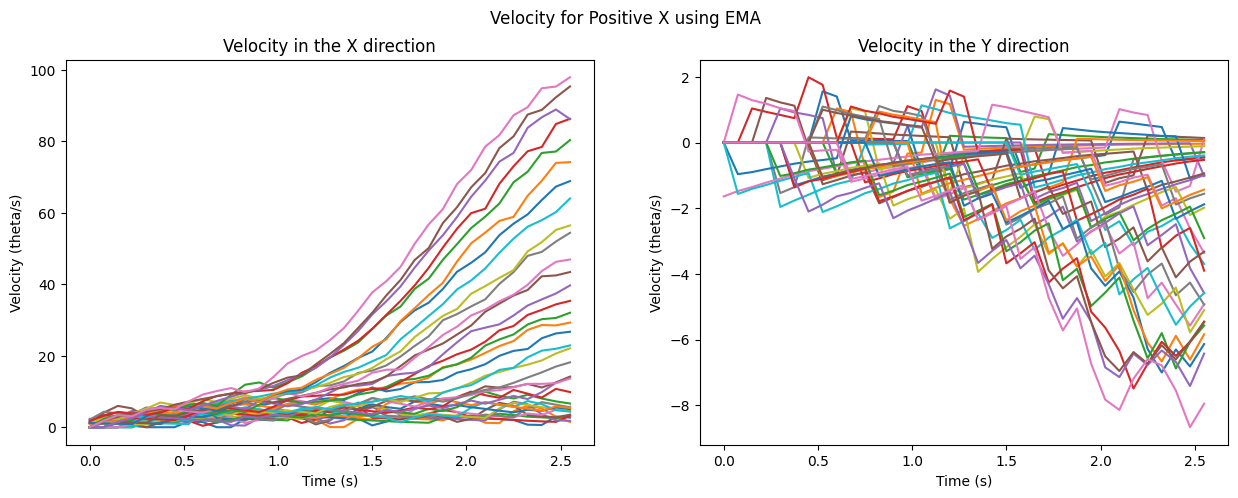

In [15]:
px_data_with_vel =  compute_velocities_ema(px_data, 'PX', alpha=alpha)
vis_vels(px_data_with_vel, 'Positive X')

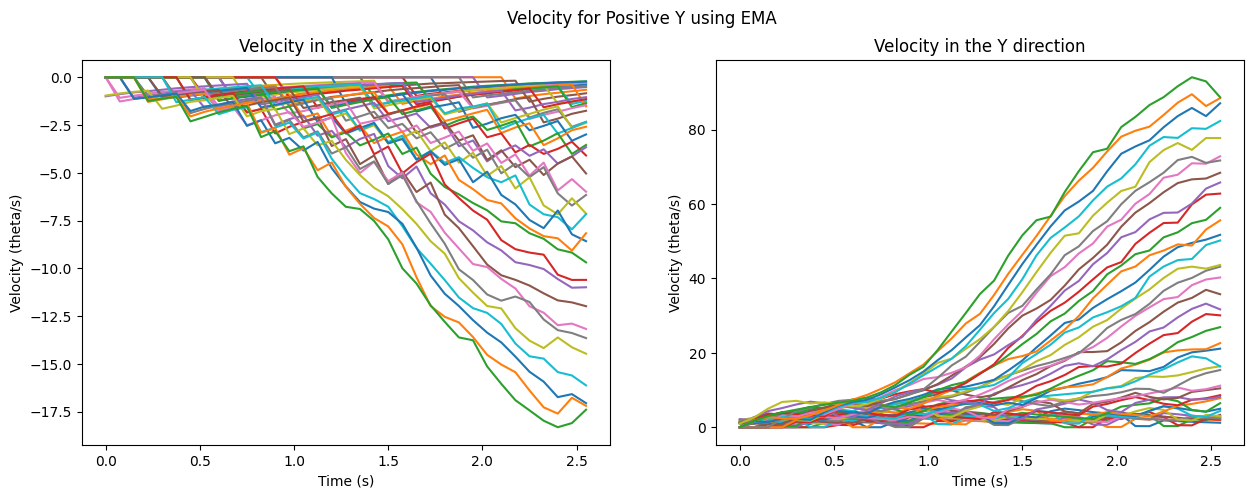

In [16]:
py_data_with_vel =  compute_velocities_ema(py_data, 'PY', alpha=alpha)
vis_vels(py_data_with_vel, 'Positive Y')

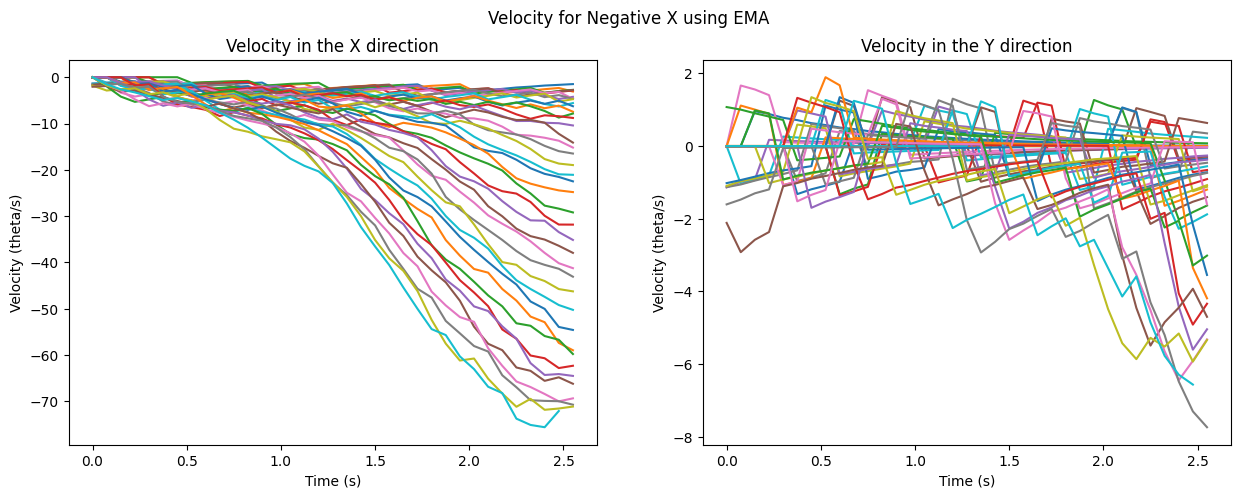

In [17]:
nx_data_with_vel =  compute_velocities_ema(nx_data, 'NX', alpha=alpha)
vis_vels(nx_data_with_vel, 'Negative X')

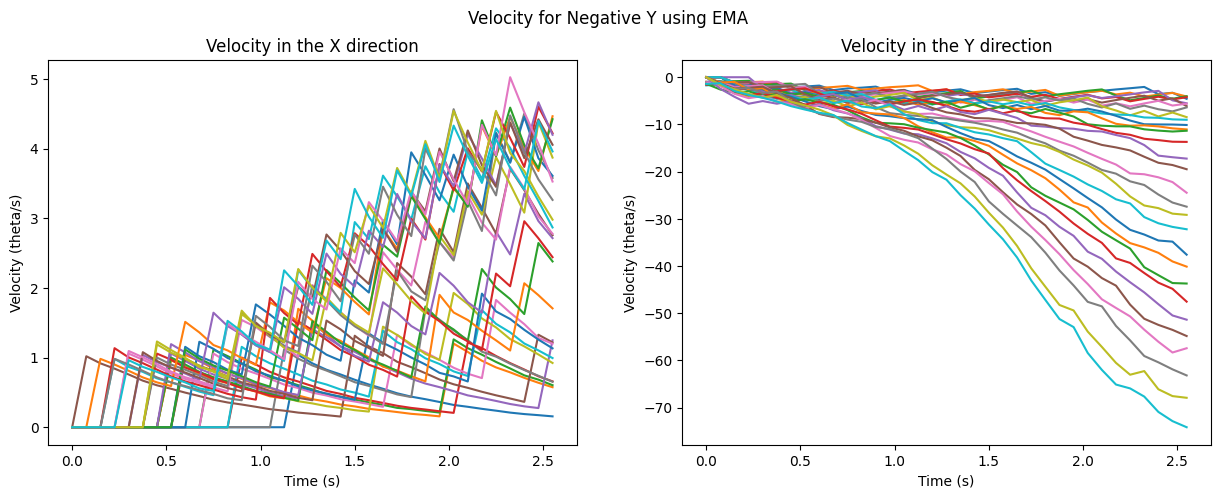

In [18]:
ny_data_with_vel =  compute_velocities_ema(ny_data, 'NY', alpha=alpha)
vis_vels(ny_data_with_vel, 'Negative Y')

In [19]:
with pd.ExcelWriter('./data/Vel_EMA.xlsx') as writer:  
    px_data_with_vel.to_excel(writer, sheet_name='Positive X')
    py_data_with_vel.to_excel(writer, sheet_name='Positive Y')
    nx_data_with_vel.to_excel(writer, sheet_name='Negative X')
    ny_data_with_vel.to_excel(writer, sheet_name='Negative Y')

In [20]:
with pd.ExcelWriter('./data/Max_vel_EMA.xlsx') as writer:  
    extract_max_vel(px_data_with_vel, 'Velocity_x', '+').to_excel(writer, sheet_name='Positive X')
    extract_max_vel(py_data_with_vel, 'Velocity_y', '+').to_excel(writer, sheet_name='Positive Y')
    extract_max_vel(nx_data_with_vel, 'Velocity_x', '-').to_excel(writer, sheet_name='Negative X')
    extract_max_vel(ny_data_with_vel, 'Velocity_y', '-').to_excel(writer, sheet_name='Negative Y')

In [21]:

data_only_vel = extract_max_vel(nx_data_with_vel, 'Velocity_x', '-')
data_only_vel

Velocity_x_min  Velocity_x_max  Velocity_x_mean  PWM_
1        -3.477504       -0.838042        -2.032606    21
2        -3.527184       -0.794890        -2.091563    22
3        -3.841701       -1.018321        -2.333663    23
0        -3.966987       -0.878926        -2.081486    20
5        -4.214681       -1.096154        -2.537411    25
6        -4.652253       -0.779892        -2.620953    26
4        -4.706744       -0.725621        -2.517639    24
7        -4.867603       -1.488462        -3.135210    27
8        -5.293920       -1.237925        -3.263317    28
10       -6.263597       -0.882692        -3.584147    30
9        -6.315481       -1.105962        -3.387405    29
11       -7.448688       -1.596226        -4.084283    31
12       -8.716834       -0.967925        -4.283318    32
13       -8.969850       -1.509434        -4.769763    33
14      -10.416390       -2.342428        -5.576050    34
15      -14.112644       -1.115660        -5.653735    35
16      -15.191122       -1.500000        -6.238076    36
17      -16.480999       -0.953308        -6.765670    37
18      -18.968460       -0.907811        -7.450818    38
19      -21.074683       -1.069811        -8.051999    39
20      -22.483986       -1.188679        -9.004366    40
21      -24.804055       -2.394340       -10.244030    41
22      -29.194053       -1.096154       -11.020051    42
23      -31.826564       -1.370769       -12.127258    43
24      -35.135529       -0.909340       -12.904623    44
25      -37.926533       -1.292885       -13.607145    45
26      -41.232809       -1.490566       -15.503754    46
27      -43.075101       -1.409434       -16.410106    47
28      -46.239168       -1.811321       -17.102656    48
29      -50.234386       -1.849057       -19.536462    49
30      -54.569267       -1.332692       -21.041566    50
31      -58.954658       -1.125000       -22.243211    51
32      -59.769332       -1.980769       -23.623278    52
33      -62.800467       -1.533333       -26.474125    53
34      -64.495104       -1.259259       -26.891118    54
35      -66.190381       -1.886538       -26.925042    55
36      -69.991967       -1.679245       -29.598918    56
37      -70.711209       -1.409434       -30.566344    57
38      -71.812328       -1.769231       -32.315366    58
39      -75.575068       -1.528302       -32.278372    59

## Rolling Window

- Main Idea is drag a window of a fixed size across the time series, and compute the velocity from the endpoints of the window
- Adjust win_len to change the window size
- Execute cells below to export results into 
  - Vel_rolling_window.xlsx (the file with all the computed velocities, timestamp etc.)
  - Max_vel_rolling_window.xlsx (the file with only the max, min and mean velocities groupby PWM values)

In [21]:
win_len = 10

In [22]:
# comput velocities EMA on the X, Y values
def compute_velocities_rolling_window(df, sma, window_length=1):
    df = df.copy()
    df['Time'] = df['Time'] / 1000
    dfs = []
    for _, group in df.groupby('PWM'):
        group['DeltaX'] = group['X'] - group['X'].shift(window_length)
        group['DeltaY'] = group['Y'] - group['Y'].shift(window_length)
        group['DeltaT'] = group['Time'] - group['Time'].shift(window_length)
        group = group.dropna()
        dfs.append(group)
    df = pd.concat(dfs, ignore_index=True)
    # filter delta x and y if they are smaller than 0.6 and set it to 0
    if sma == 'PX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'PY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'NX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x > 0 else x)
    elif sma == 'NY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x > 0 else x)
    df['Velocity_x'] = df['DeltaX'] / df['DeltaT']
    df['Velocity_y'] = df['DeltaY'] / df['DeltaT']
    df.loc[df['PWM'] == 0, 'Velocity_x'] = 0
    df.loc[df['PWM'] == 0, 'Velocity_y'] = 0

    return df

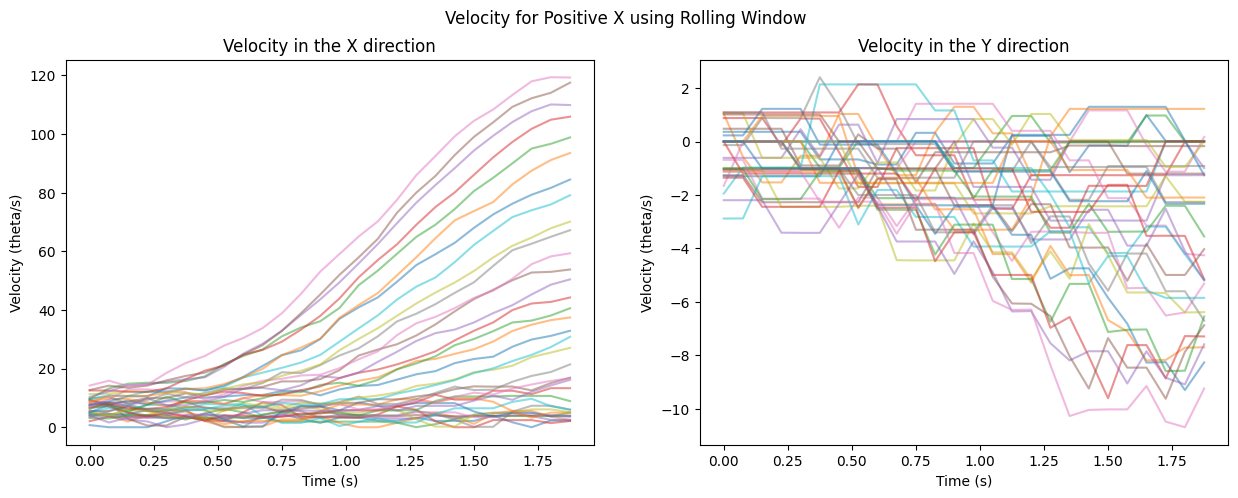

In [23]:
px_data_win =  compute_velocities_rolling_window(px_data, 'PX', window_length=win_len)
vis_vels(px_data_win, 'Positive X', filter='Rolling Window')

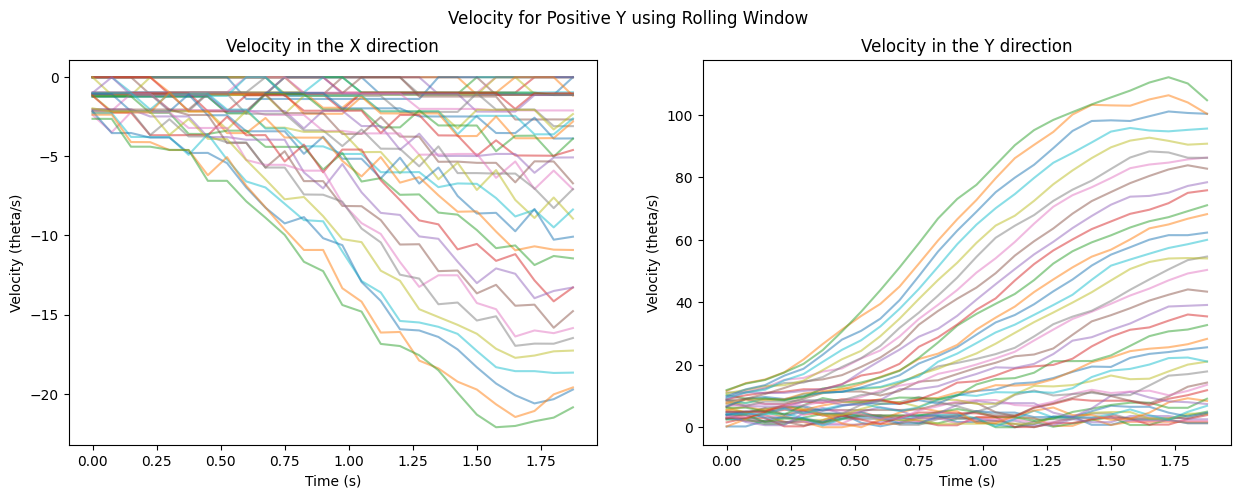

In [24]:
py_data_win =  compute_velocities_rolling_window(py_data, 'PY', window_length=win_len)
vis_vels(py_data_win, 'Positive Y', filter='Rolling Window')

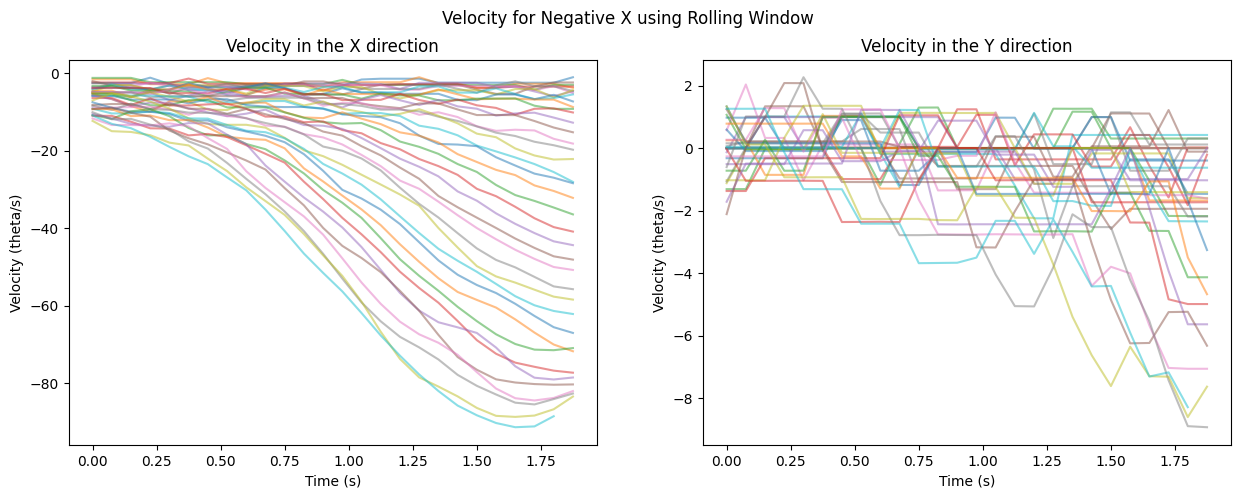

In [25]:
nx_data_win =  compute_velocities_rolling_window(nx_data, 'NX', window_length=win_len)
vis_vels(nx_data_win, 'Negative X', filter='Rolling Window')

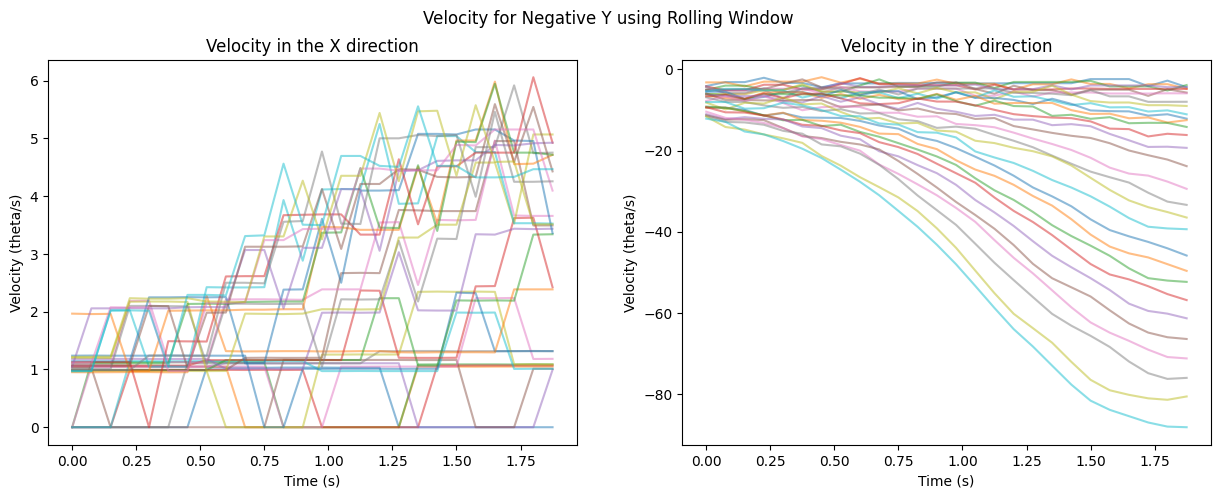

In [26]:
ny_data_win =  compute_velocities_rolling_window(ny_data, 'NY', window_length=win_len)
vis_vels(ny_data_win, 'Negative Y', filter='Rolling Window')

In [27]:
with pd.ExcelWriter('./data/Vel_rolling_window.xlsx') as writer:  
    px_data_win.to_excel(writer, sheet_name='Positive X')
    py_data_win.to_excel(writer, sheet_name='Positive Y')
    nx_data_win.to_excel(writer, sheet_name='Negative X')
    ny_data_win.to_excel(writer, sheet_name='Negative Y')

In [28]:
with pd.ExcelWriter('./data/Max_vel_rolling_win.xlsx') as writer:
    extract_max_vel(px_data_win, 'Velocity_x', '+').to_excel(writer, sheet_name='Positive X')
    extract_max_vel(py_data_win, 'Velocity_y', '+').to_excel(writer, sheet_name='Positive Y')
    extract_max_vel(nx_data_win, 'Velocity_x', '-').to_excel(writer, sheet_name='Negative X')
    extract_max_vel(ny_data_win, 'Velocity_y', '-').to_excel(writer, sheet_name='Negative Y')  

## Decrease Sample Rate

- Main Idea is to decrase the sampling rate by only using every nth datapoint to compute the velocity
  - Can be thought of as a rollig window with win_len of n and stride of n
- Adjust skip to get every "skip"th data point
- Execute cells below to export results into 
  - Vel_decreased_sample.xlsx (the file with all the computed velocities, timestamp etc.)
  - Max_vel_decreased_sample.xlsx (the file with only the max, min and mean velocities groupby PWM values)

In [30]:
skip = 10

In [31]:

def compute_velocities_decrease_samples(df, sma, skip=2):
    df = df.copy()
    df['Time'] = df['Time'] / 1000
    dfs = []
    for _, group in df.groupby('PWM'):
        group = group.iloc[::skip].copy()
        group['DeltaX'] = group['X'] - group['X'].shift()
        group['DeltaY'] = group['Y'] - group['Y'].shift()
        group['DeltaT'] = group['Time'] - group['Time'].shift()
        group = group.dropna()
        dfs.append(group)
    df = pd.concat(dfs, ignore_index=True)
    # filter delta x and y if they are smaller than 0.6 and set it to 0
    if sma == 'PX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'PY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x < 0 else x)
    elif sma == 'NX':
        df['DeltaX'] = df['DeltaX'].apply(lambda x: 0 if x > 0 else x)
    elif sma == 'NY':
        df['DeltaY'] = df['DeltaY'].apply(lambda x: 0 if x > 0 else x)
    df['Velocity_x'] = df['DeltaX'] / df['DeltaT']
    df['Velocity_y'] = df['DeltaY'] / df['DeltaT']
    df.loc[df['PWM'] == 0, 'Velocity_x'] = 0
    df.loc[df['PWM'] == 0, 'Velocity_y'] = 0

    return df

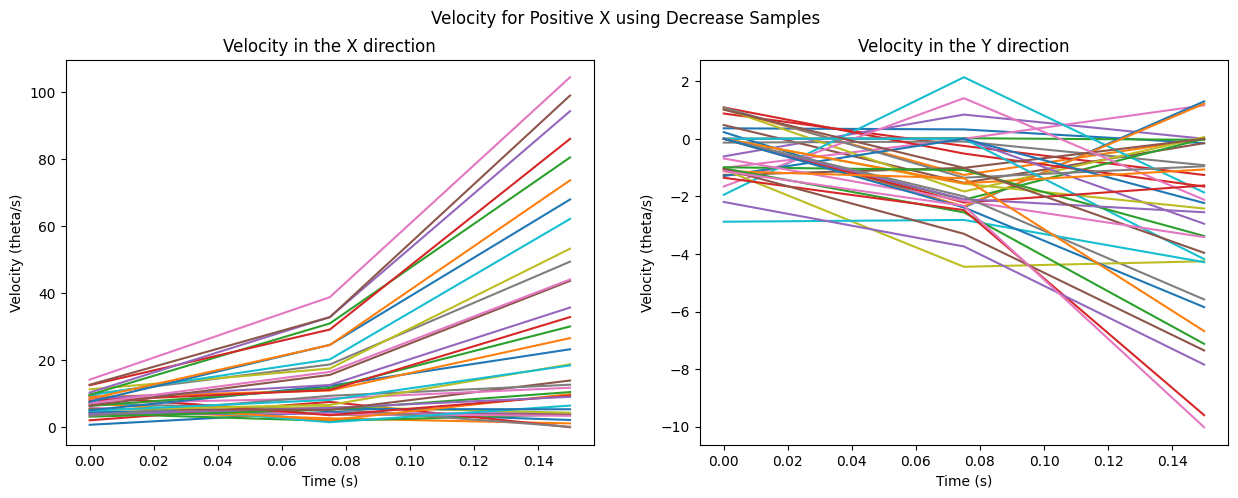

In [32]:
px_data_dec =  compute_velocities_decrease_samples(px_data, 'PX', skip=skip)
vis_vels(px_data_dec, 'Positive X', filter='Decrease Samples')

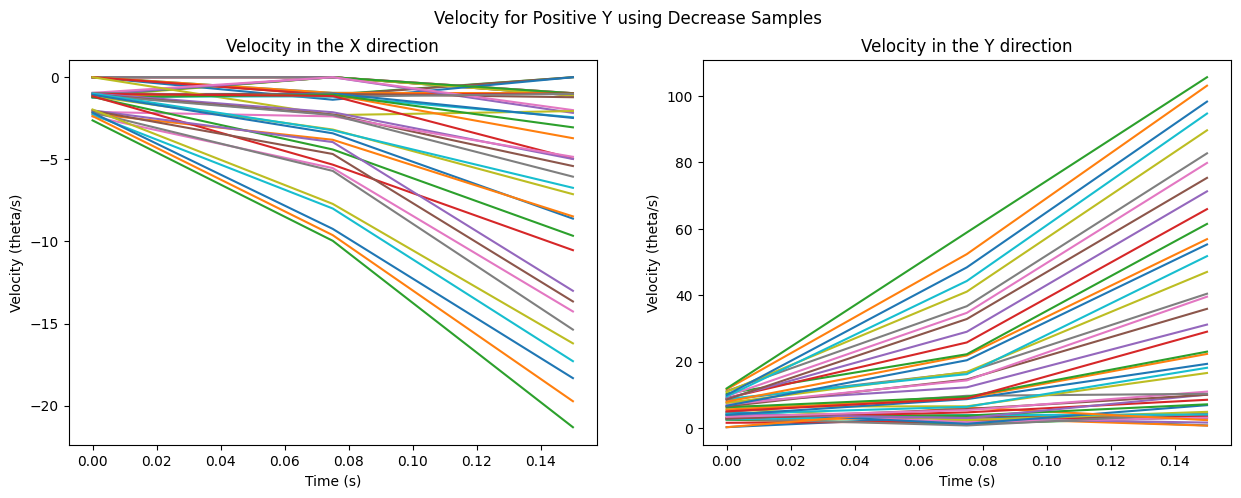

In [33]:
py_data_dec =  compute_velocities_decrease_samples(py_data, 'PY', skip=skip)
vis_vels(py_data_dec, 'Positive Y', filter='Decrease Samples')

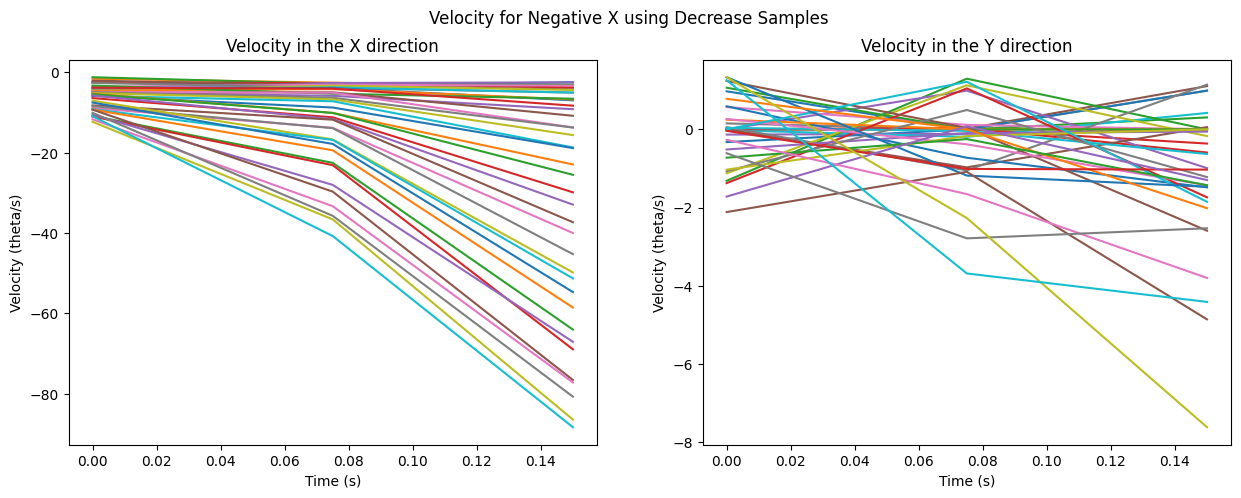

In [34]:
nx_data_dec =  compute_velocities_decrease_samples(nx_data, 'NX', skip=skip)
vis_vels(nx_data_dec, 'Negative X', filter='Decrease Samples')

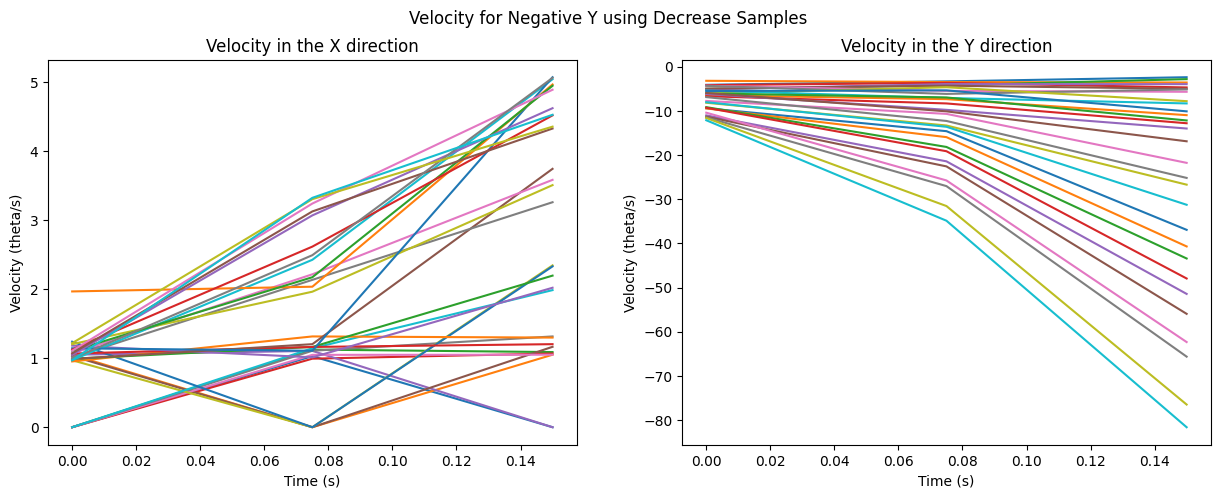

In [35]:
ny_data_dec =  compute_velocities_decrease_samples(ny_data, 'NY', skip=skip)
vis_vels(ny_data_dec, 'Negative Y', filter='Decrease Samples')

In [36]:
with pd.ExcelWriter('./data/Vel_decreased_sample.xlsx') as writer:  
    px_data_dec.to_excel(writer, sheet_name='Positive X')
    py_data_dec.to_excel(writer, sheet_name='Positive Y')
    nx_data_dec.to_excel(writer, sheet_name='Negative X')
    ny_data_dec.to_excel(writer, sheet_name='Negative Y')

In [37]:
with pd.ExcelWriter('./data/Max_vel_decreased_sample.xlsx') as writer: 
    extract_max_vel(px_data_dec, 'Velocity_x', '+').to_excel(writer, sheet_name='Positive X')
    extract_max_vel(py_data_dec, 'Velocity_y', '+').to_excel(writer, sheet_name='Positive Y')
    extract_max_vel(nx_data_dec, 'Velocity_x', '-').to_excel(writer, sheet_name='Negative X')
    extract_max_vel(ny_data_dec, 'Velocity_y', '-').to_excel(writer, sheet_name='Negative Y') 

In [ ]:
# Generating figure plots

In [ ]:
def vis_vels(df, sma, delta_t=0.075, filter='EMA'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for _, group in df.groupby('PWM'):
        axs[0].plot(np.arange(len(group))*delta_t, group['Velocity_x'], alpha=0.5)
        axs[1].plot(np.arange(len(group))*delta_t, group['Velocity_y'], alpha=0.5)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Velocity (theta/s)')
    axs[0].set_title(f'Velocity in the X direction')

    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity (theta/s)')
    axs[1].set_title(f'Velocity in the Y direction')
    fig.suptitle(f'Velocity for {sma} using {filter} ')
    plt.show()

In [31]:
px_data_win =  compute_velocities_rolling_window(px_data, 'PX', window_length=5)
nx_data_win =  compute_velocities_rolling_window(nx_data, 'NX', window_length=5)

In [34]:
extract_max_vel(px_data_win, 'Velocity_x', '+')

Velocity_x_max  Velocity_x_min  Velocity_x_mean  PWM_
0         7.088123        0.344828         2.960440    20
2         7.633588        2.099237         4.315410    22
1         8.045977        0.267176         4.821324    21
3         9.693487        0.534351         4.781357    23
5         9.885496        0.114504         5.954221    25
4        11.870229        0.494297         6.071238    24
6        12.022901        0.383142         6.246220    26
7        12.022901        0.344828         6.057952    27
8        12.213740        1.946565         6.182394    28
9        14.083969        0.038168         6.088719    29
11       14.465649        2.137405         6.380586    31
10       14.503817        0.076336         5.876576    30
13       17.404580        0.458015         7.721829    33
12       17.709924        0.305344         6.158549    32
16       18.206107        3.931298        10.003249    36
15       18.244275        0.380228         9.206165    35
14       22.442748        0.839695         7.128828    34
17       27.519084        2.290076        10.643663    37
18       30.916031        2.213740        12.426766    38
19       34.732824        2.099237        13.156303    39
20       38.244275        2.813688        16.471022    40
21       41.908397        5.703422        18.602402    41
22       45.076336        3.625954        19.318473    42
23       49.657795        2.709924        21.034799    43
24       54.122137        4.885496        23.146020    44
25       60.496183        3.206107        26.395290    45
26       65.171103        6.349810        28.269171    46
27       74.847328        5.648855        31.513633    47
28       79.353612        8.893130        33.467135    48
29       84.030418        6.679389        37.293030    49
30       91.374046        6.870229        40.811998    50
31       99.961977        7.824427        43.556945    51
32      106.387833        8.549618        48.907006    52
33      114.503817        5.877863        51.387406    53
34      117.862595        9.007634        55.406310    54
35      122.965779       10.532319        57.821938    55
36      124.847328        9.885496        62.062183    56

In [35]:
extract_max_vel(nx_data_win, 'Velocity_x', '-')

Velocity_x_min  Velocity_x_max  Velocity_x_mean  PWM_
1        -5.419847       -2.053232        -2.988406    21
3        -5.610687       -1.946565        -3.512547    23
2        -6.068702       -2.213740        -2.889726    22
5        -6.412214       -1.946565        -3.988158    25
0        -6.488550       -2.061069        -3.477663    20
6        -6.539924       -2.053232        -3.482524    26
4        -6.832061       -2.083333        -3.968759    24
7        -8.098859       -1.946565        -4.296243    27
8        -8.712121       -2.159091        -4.217354    28
9        -8.740458       -2.015209        -4.568786    29
10       -8.745247       -2.167300        -4.931023    30
11      -10.648855       -2.623574        -5.579938    31
12      -12.623574       -2.167300        -5.840358    32
13      -12.889734       -2.175573        -6.748951    33
14      -15.305344       -3.003802        -7.770362    34
15      -20.839695       -2.775665        -8.213086    35
16      -21.106870       -2.022901        -9.345845    36
17      -22.748092       -2.595420       -10.120914    37
18      -29.657795       -2.509506       -11.509986    38
19      -29.885496       -1.901141       -12.858261    39
20      -30.839695       -2.661597       -13.748614    40
21      -36.730038       -5.209125       -15.688835    41
22      -42.824427       -2.205323       -17.374825    42
23      -43.041825       -3.358779       -19.167716    43
24      -46.870229       -1.901141       -20.771159    44
25      -51.603053       -5.037879       -22.739922    45
26      -55.437262       -5.133080       -24.772005    46
27      -56.755725       -4.220532       -26.695550    47
28      -63.244275       -4.351145       -28.438908    48
29      -66.083650       -5.019011       -31.039705    49
30      -71.984733       -2.938931       -32.806750    50
32      -72.786260       -6.374046       -37.588409    52
31      -77.442748       -5.703422       -35.466707    51
33      -83.574144       -3.498099       -40.811487    53
34      -84.847328       -9.353612       -42.335875    54
35      -87.557252       -7.442748       -44.153157    55
37      -89.467681       -5.171103       -48.750569    57
36      -90.954198       -9.122137       -47.087569    56
38      -92.015209       -7.900763       -50.942721    58
39      -95.801527       -9.160305       -52.040000    59

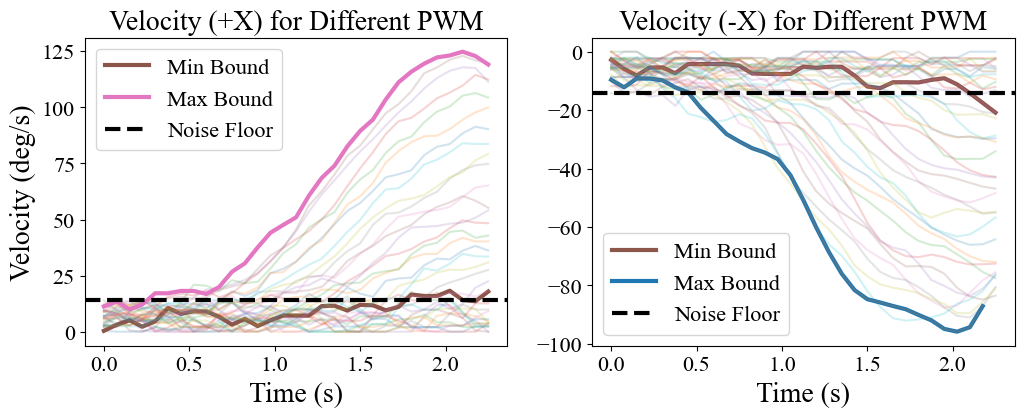

In [62]:
plt.rcParams['font.family'] = 'Times New Roman'
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
dt = 0.075
for _, group in px_data_win.groupby('PWM'):
    if group['PWM'].values[0] == 35:
        axs[0].plot(np.arange(len(group))*dt, group['Velocity_x'], label='Min Bound', linewidth=3)
    elif group['PWM'].values[0] == 56:
        axs[0].plot(np.arange(len(group))*dt, group['Velocity_x'], label='Max Bound', linewidth=3)
    else:
        axs[0].plot(np.arange(len(group))*dt, group['Velocity_x'], alpha=0.2)
axs[0].axhline(14, color='black', linestyle='--', label='Noise Floor', linewidth=3)
for _, group in nx_data_win.groupby('PWM'):
    if group['PWM'].values[0] == 35:
        axs[1].plot(np.arange(len(group))*dt, group['Velocity_x'], label='Min Bound', linewidth=3)
    elif group['PWM'].values[0] == 59:
        axs[1].plot(np.arange(len(group))*dt, group['Velocity_x'], label='Max Bound', linewidth=3)
    axs[1].plot(np.arange(len(group))*dt, group['Velocity_x'], alpha=0.2)
axs[1].axhline(-14, color='black', linestyle='--', label='Noise Floor', linewidth=3)
axs[0].set_xlabel('Time (s)', fontsize=20)
axs[0].set_ylabel('Velocity (deg/s)', fontsize=20)
axs[0].set_title('Velocity (+X) for Different PWM', fontsize=20)
axs[1].set_xlabel('Time (s)', fontsize=20)
axs[1].set_title('Velocity (-X) for Different PWM', fontsize=20)
axs[1].legend(fontsize=16)
axs[0].legend(fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=16)

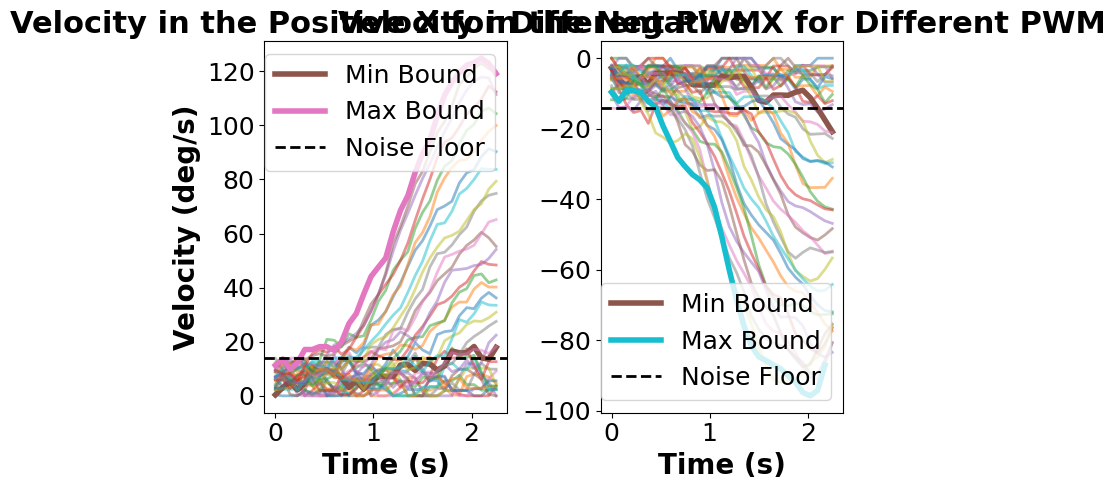

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Adjust the figure size to the intended display size
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

dt = 0.075
for _, group in px_data_win.groupby('PWM'):
    pwm_value = group['PWM'].values[0]
    time = np.arange(len(group)) * dt
    velocity = group['Velocity_x']
    if pwm_value == 35:
        axs[0].plot(time, velocity, label='Min Bound', linewidth=4)
    elif pwm_value == 56:
        axs[0].plot(time, velocity, label='Max Bound', linewidth=4)
    else:
        axs[0].plot(time, velocity, alpha=0.5, linewidth=2)

axs[0].axhline(14, color='black', linestyle='--', label='Noise Floor', linewidth=2)

for _, group in nx_data_win.groupby('PWM'):
    pwm_value = group['PWM'].values[0]
    time = np.arange(len(group)) * dt
    velocity = group['Velocity_x']
    if pwm_value == 35:
        axs[1].plot(time, velocity, label='Min Bound', linewidth=4)
    elif pwm_value == 59:
        axs[1].plot(time, velocity, label='Max Bound', linewidth=4)
    else:
        axs[1].plot(time, velocity, alpha=0.5, linewidth=2)

axs[1].axhline(-14, color='black', linestyle='--', label='Noise Floor', linewidth=2)

# Set labels and titles with increased font sizes and bold weight
axs[0].set_xlabel('Time (s)', fontsize=20, fontweight='bold')
axs[0].set_ylabel('Velocity (deg/s)', fontsize=20, fontweight='bold')
axs[0].set_title('Velocity in the Positive X for Different PWM', fontsize=22, fontweight='bold')

axs[1].set_xlabel('Time (s)', fontsize=20, fontweight='bold')
axs[1].set_title('Velocity in the Negative X for Different PWM', fontsize=22, fontweight='bold')

# Adjust tick parameters for better legibility
axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=18)

# Set legend font sizes
axs[0].legend(fontsize=18)
axs[1].legend(fontsize=18)

# Tight layout to prevent clipping of labels and titles
plt.tight_layout()

# Save the figure with a high resolution
plt.savefig('velocity_plots.png', dpi=300)
plt.show()
